<a href="https://colab.research.google.com/github/charlesm93/nested-rhat/blob/main/Bias_Variance_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $(\delta, \delta')$-reliability of $\mathfrak n 
\widehat R$

A set of experiments to investigate the bias-variance decomposition of MCMC on a standard Gaussian (or mixture of two Gaussians). The goal is to understand the initialization conditions under which $\mathfrak n \widehat R$ is reliable.

Copyright 2022 Charles C. Margossian



In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

In [ ]:
# Pavel's code to get fun_mc running 
!rm -Rf probability
!rm -Rf fun_mc
!rm -Rf inference_gym
!git clone https://github.com/tensorflow/probability.git
!mv probability/spinoffs/fun_mc/fun_mc .
!mv probability/spinoffs/inference_gym/inference_gym .
!pip install tf-nightly tfp-nightly jax jaxlib

Cloning into 'probability'...
remote: Enumerating objects: 96077, done.
remote: Counting objects: 100% (1080/1080), done.
remote: Compressing objects: 100% (482/482), done.
remote: Total 96077 (delta 693), reused 906 (delta 594), pack-reused 94997
Receiving objects: 100% (96077/96077), 134.05 MiB | 17.03 MiB/s, done.
Resolving deltas: 100% (77873/77873), done.
Checking out files: 100% (1385/1385), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 582.2 MB 27 kB/s 
     |████████████████████████████████| 6.6 MB 6.0 MB/s 
     |████████████████████████████████| 1.7 MB 48.6 MB/s 
     |████████████████████████████████| 5.9 MB 57.4 MB/s 
     |████████████████████████████████| 439 kB 74.7 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3


In [ ]:
!pip install immutabledict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# from colabtools import adhoc_import  (only needed inside Google)
from contextlib import ExitStack

from fun_mc import using_jax as fun_mc

# ADHOC = True
# CLIENT = 'fig-export-fig_tree-change-451-3e0a679e9746'

import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions

from inference_gym import using_jax as gym


In [ ]:
from functools import partial

In [ ]:
from google.colab import files  # use this download saved plots

## Tools

In [ ]:
# For a given kernel, runs 'replicas' super chains, each made up of
# 'num_chains' chains and N = 1 sample. Estimate B / W.
# Estimate the expected squared error, expected squared bias and check
# the index after which B / W < delta.
def run_experiment(kernel, target_log_prob_fn, num_warmup,
                   init_dist, delta, replicas, num_chains):
  # initialize all chains within a group at the same point
  init = init_dist.sample([replicas // num_chains], seed=jax.random.PRNGKey(0))
  init_x = jnp.repeat(init, num_chains, axis = 0)

  _, (chain, is_accepted) = fun_mc.trace(
      (fun_mc.hamiltonian_monte_carlo_init(init_x, target_log_prob_fn),
       jax.random.PRNGKey(0)), kernel, num_warmup)

  # sort chains by groups of chains
  chain = chain.reshape(num_warmup, replicas // num_chains, num_chains)

  # Compute Monte Carlo estimators (using N = 1, after W warmup)
  super_mean = jnp.mean(chain, axis = 2)
  var_mc = jnp.var(super_mean, axis = 1)             # B
  var_within = jnp.var(chain, axis = 2)
  mean_var_within = jnp.mean(var_within, axis = 1)   # W

  # Estimate squared error
  true_mean = 0
  squared_err_mc = jnp.mean(jnp.square(super_mean - true_mean), 1)

  # Estimate squared bias
  bias_2_mc = squared_err_mc - var_mc

  B_W = var_mc / mean_var_within

  # Check condition for whether variance is a good proxy for error.
  search_index = jnp.where(B_W <= delta)
  if (len(search_index[0] >= 1)):
    index_convergence = jnp.where(B_W <= delta)[0][0]
    converged = True
  else:
    index_convergence = 0
    converged = False

  return squared_err_mc[index_convergence], bias_2_mc[index_convergence], converged, chain


In [ ]:
def sigma_bound(mu0, num_chains, delta, delta_prime, sigma = 1):
  return (delta - 1 / num_chains) * (mu0**2 / (delta_prime * sigma**2) - 1) * sigma**2


In [ ]:
num_chains = 16               # size of a super-chain (also number of samples)
replicas = num_chains * 1024  # 1024  # repeat experiment for sample estimates

## Standard Gaussian target

In [ ]:
dist = tfd.Normal(0., 1.)

# tuning parameters for basic HMC
num_warmup = 20000

def target_log_prob_fn(x):
  return dist.log_prob(x), ()

def kernel(hmc_state, seed):
  hmc_seed, seed = jax.random.split(seed)
  hmc_state, hmc_extra = fun_mc.hamiltonian_monte_carlo_step(
      hmc_state,
      target_log_prob_fn=target_log_prob_fn,
      step_size=.05,
      num_integrator_steps=1,
      seed=hmc_seed)
  return (hmc_state, seed), (hmc_state.state, hmc_extra.is_accepted)


In [ ]:
delta = (1 / num_chains) * 1.5
delta_prime = delta / 5
mu0_vec = jnp.linspace(start = 0., stop = 12., num = 100)
lower_bound = sigma_bound(mu0_vec, num_chains, delta, delta_prime)

In [ ]:
mu0 = jnp.array([0.,
                 1., 1., 1., 1., 1.,
                 5., 5., 5., 5., 5., 5.,
                 7., 7., 7., 7., 7., 7., 7., 7.,
                 9., 9., 9., 9., 9., 9., 9., 9.,
                 12., 12., 12., 12., 12., 12., 12., 12.])

sigma0 = 2 * jnp.array([1.,
                    .3, .4, .5, .6, .7, 
                    1., 1.5, 2., 2.5, 3., 3.5,
                    1., 1.5, 2, 2.5, 3, 3.5, 4, 4.5,
                    2, 2.5, 3., 3.5, 4., 4.5, 5., 5.5, 
                    2.5, 4, 4.5, 5, 5.5, 6., 6.5, 7]) * 1.3


In [ ]:
squared_error = []
squared_bias = []
converged = []
for i in range(0, mu0.shape[0]):
  init_dist = tfd.Normal(mu0[i], sigma0[i])

  squared_error_local, squared_bias_local, converged_local, chain =\
    run_experiment(kernel = kernel, target_log_prob_fn = target_log_prob_fn,
                   num_warmup = num_warmup, init_dist = init_dist,
                   delta = delta, replicas = replicas, num_chains = num_chains)
  
  squared_error.append(squared_error_local)
  squared_bias.append(squared_bias_local)
  converged.append(converged_local)


In [ ]:
reliable = (jnp.array(converged) < 1) | (jnp.array(squared_bias) < delta_prime)

In [ ]:
jnp.transpose(jnp.array(converged))

DeviceArray([ True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True,  True,  True,  True,  True,
              True,  True,  True,  True], dtype=bool)

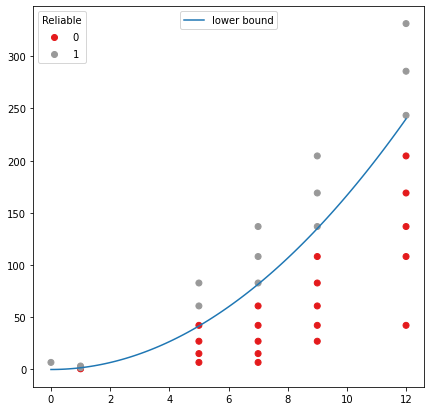

In [ ]:
fig, ax = plt.subplots(figsize = [7, 7])

scatter = ax.scatter(mu0, jnp.square(sigma0), c = reliable, alpha = 1.0, cmap = "Set1")
line = ax.plot(mu0_vec, lower_bound, label = 'lower bound')

legend1 = ax.legend(*scatter.legend_elements(),
                   loc="best", title="Reliable")
ax.add_artist(legend1)
ax.legend(loc = "upper center")

fig.show()

## Mixture of Gaussians

In [ ]:
dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.2, 0.8]), 
    components_distribution=tfd.Normal(
      loc=[-8, 2],
      scale=[1, 1]))

# tuning parameters for basic HMC
n_steps = 100
num_samples = 10000

def target_log_prob_fn(x):
  return dist.log_prob(x), ()

def kernel(hmc_state, seed):
  hmc_seed, seed = jax.random.split(seed)
  hmc_state, hmc_extra = fun_mc.hamiltonian_monte_carlo_step(
      hmc_state,
      target_log_prob_fn=target_log_prob_fn,
      step_size=1,
      num_integrator_steps=1,
      seed=hmc_seed)
  return (hmc_state, seed), (hmc_state.state, hmc_extra.is_accepted)

In [ ]:
squared_error_mixed = []
squared_bias_mixed = []
converged_mixed = []
for i in range(0, mu0.shape[0]):
  init_dist = tfd.Normal(mu0[i], sigma0[i])

  squared_error_local, squared_bias_local, converged_local, chain =\
    run_experiment(kernel = kernel, target_log_prob_fn = target_log_prob_fn,
                   num_warmup = num_warmup, init_dist = init_dist,
                   delta = delta, replicas = replicas, num_chains = num_chains)
  
  squared_error_mixed.append(squared_error_local)
  squared_bias_mixed.append(squared_bias_local)
  converged_mixed.append(converged_local)


In [ ]:
reliable_mixed = (jnp.array(converged_mixed) < 1) | (jnp.array(squared_bias_mixed) < delta_prime)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

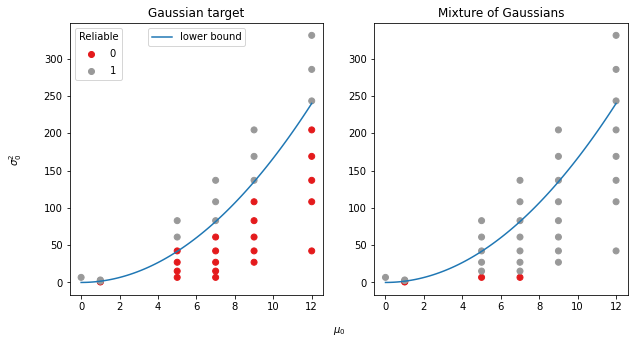

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = [10, 5])

scatter = ax[0].scatter(mu0, jnp.square(sigma0), c = reliable, alpha = 1.0, cmap = "Set1")
line = ax[0].plot(mu0_vec, lower_bound, label = 'lower bound')

scatter_mixed = ax[1].scatter(mu0, jnp.square(sigma0), c = reliable_mixed, alpha = 1.0, cmap = "Set1")
line_mixed = ax[1].plot(mu0_vec, lower_bound, label = 'lower bound')

legend1 = ax[0].legend(*scatter.legend_elements(),
                   loc="best", title="Reliable")
ax[0].add_artist(legend1)
ax[0].legend(loc = "upper center")

ax[0].set_title("Gaussian target")
ax[1].set_title("Mixture of Gaussians")

fig.text(0.05, 0.5, '$\sigma_0^2$', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.025, "$\mu_0$", ha="center", va="center")

fig.savefig("reliable.pdf")
files.download("reliable.pdf")

In [ ]:
fig, ax = plt.subplots(1, 2, sharey = False, sharex = True,
                   figsize=(8, 4))
ax[0].plot(between_reg_uni, label='single chain')
ax[0].plot(between_nested_uni, label='super chain')
ax[0].plot(between_nested_naive_uni, label = 'super chain (naive)')
ax[0].legend(loc = "bottom left")
ax[0].set_title("Unimodal target")

ax[0].set_yscale('log')

ax[1].plot(between_reg, label='single chain')
ax[1].plot(between_nested, label='super chain')
ax[1].plot(between_nested_naive, label = 'super chain (naive)')
ax[1].set_title("Bimodal target")

ax[1].set_xscale('log')
ax[1].set_yscale('log')
# ax[1].set_xlabel('Chain Length')

fig.text(0.05, 0.5, 'Variance of Monte Carlo Estimator', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.025, "Chain Length", ha="center", va="center")

## Banana

In [ ]:
dist = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.2, 0.8]), 
    components_distribution=tfd.Normal(
      loc=[-8, 2],
      scale=[1, 1]))

# tuning parameters for basic HMC
n_steps = 100
num_samples = 10000

target = gym.targets.VectorModel(gym.targets.Banana(),
                                  flatten_sample_transformations=True)
num_dimensions = target.event_shape[0]  
init_step_size = 1.

def target_log_prob_fn(x):
  """Unnormalized, unconstrained target density.
  
  This is a thin wrapper that applies the default bijectors so that we can
  ignore any constraints.
  """
  y = target.default_event_space_bijector(x)
  fldj = target.default_event_space_bijector.forward_log_det_jacobian(x)
  return target.unnormalized_log_prob(y) + fldj


def kernel(hmc_state, seed):
  hmc_seed, seed = jax.random.split(seed)
  hmc_state, hmc_extra = fun_mc.hamiltonian_monte_carlo_step(
      hmc_state,
      target_log_prob_fn=target_log_prob_fn,
      step_size=0.5,
      num_integrator_steps=1,
      seed=hmc_seed)
  return (hmc_state, seed), (hmc_state.state, hmc_extra.is_accepted)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:4457: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


In [ ]:
# parameters for initial distributions
init_param = jnp.array([[0, 1], 
                        [1, .01], [1, .1], [1, 1], 
                        [10, .1], [10, 1], [10, 10], [10, 30],
                        [20, .1], [20, 1], [20, 10], [20, 60]])

# tolerance for Monte Carlo variance
delta = 0.02

## Draft code

In [ ]:
# initial distributions
dist_bias = tfd.Normal(50., 50)  # bias, mildly dispersed

In [ ]:
# Draw sample from underdispersed bias distribution
init_x = dist_bias.sample([replicas], seed=jax.random.PRNGKey(0))

_, (chain, is_accepted) = fun_mc.trace((fun_mc.hamiltonian_monte_carlo_init(init_x,
    target_log_prob_fn), jax.random.PRNGKey(0)), kernel, num_samples)

chain = jnp.concatenate([init_x[jnp.newaxis], chain], 0)

# sort chains by groups of chains
chain = chain.reshape(num_samples + 1, num_chains, replicas // num_chains)

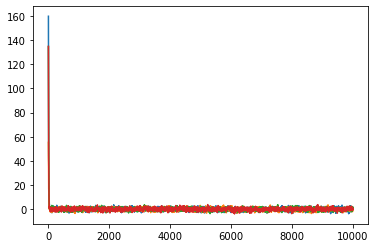

In [ ]:
# check mixing
plt.plot(chain[:, :, 0])
plt.show()

In [ ]:
# i = 10
# mean_var_local = jnp.mean(jnp.var(chain[:i, :, :], axis = 0, ddof=1), axis = 0)
# mean_var_local.shape

# # @partial(jnp.vectorize, signature = None)
# def mean_within_chain_variance(index):
#   return jnp.mean(jnp.var(chain[:index,:,:], axis = 0, ddof = 1), axis = 0)

# vectorize_W = jax.vmap(mean_within_chain_variance)

# index_arg = jnp.arange(1, chain.shape[0] + 1).astype(int)

# var_local = vectorize_W(index_arg)

In [ ]:
# Compute Monte Carlo estimators (using two chains for each)
cum_mc = jnp.sum(jnp.cumsum(chain, 0), 1) / jnp.arange(1, chain.shape[0] + 1)[:, jnp.newaxis]

# Estimate variance of Monte Carlo estimators
var_mc = cum_mc.var(1)

# Estimate mean within-chain variance
# For now, set it to 1 (which is its asymptotic value...)
# TODO: find a fast way to compute W...
var_within_chain = jnp.repeat(1, num_samples + 1)

# Estimate squared error
true_mean = 0
squared_err_mc = jnp.mean(jnp.square(cum_mc - true_mean), 1)

# Estimate squared bias
bias_2_mc = squared_err_mc - var_mc

# Check condition for whether variance is a good proxy for error.
index_conv = jnp.where(var_mc <= 0.02)[0][0]
print("squared_err", squared_err_mc[index_conv])


squared_err 0.070196316


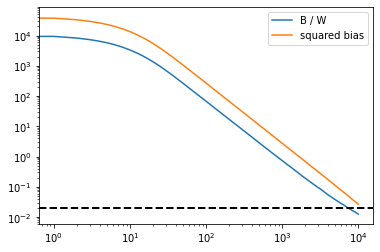

In [ ]:
plt.plot(var_mc, label = 'B / W')
# plt.plot(squared_err_mc, label = 'squared error')
plt.plot(bias_2_mc, label = 'squared bias')
plt.xscale('log')
plt.yscale('log')
plt.axhline(2 * 1e-2, ls='--', color='black', lw=2)
plt.legend()
plt.show()

In [ ]:
# dist = tfd.MixtureSameFamily(
#     mixture_distribution=tfd.Categorical(probs=[0.3, 0.7]), 
#     components_distribution=tfd.Normal(
#       loc=[-5, 5],
#       scale=[1, 1]))

In [ ]:
# For a given MCMC kernel and initial distribution,
# evaluate the squared bias after which the scaled variance
# is below a certain threshold delta.
#
# DEPRECATED -- used for multiple chains.
def run_experiment_deprecated(kernel, target_log_prob_fn, num_samples,
                   init_dist, delta, replicas, num_chains):
  init_x = init_dist.sample([replicas], seed=jax.random.PRNGKey(0))

  _, (chain, is_accepted) = fun_mc.trace((fun_mc.hamiltonian_monte_carlo_init(init_x,
      target_log_prob_fn), jax.random.PRNGKey(0)), kernel, num_samples)

  chain = jnp.concatenate([init_x[jnp.newaxis], chain], 0)

  # sort chains by groups of chains
  chain = chain.reshape(num_samples + 1, num_chains, replicas // num_chains)

  # Compute Monte Carlo estimators (using num_chains)
  cum_mc = jnp.sum(jnp.cumsum(chain, 0), 1) / jnp.arange(1, chain.shape[0] + 1)[:, jnp.newaxis]

  # Estimate variance of Monte Carlo estimators
  var_mc = cum_mc.var(axis = 1)

  # Estimate mean within-chain variance
  # TODO: find a fast way to compute W...
  # var_within_chain = jnp.repeat(1, num_samples + 1)
  var_within_chain = jnp.var(mean, axis = 1)

  # Estimate squared error
  true_mean = 0
  squared_err_mc = jnp.mean(jnp.square(super_mean - true_mean), 1)

  # Estimate squared bias
  bias_2_mc = squared_err_mc - var_mc

  # Check condition for whether variance is a good proxy for error.
  search_index = jnp.where(var_mc / var_within_chain <= delta)
  if (len(search_index[0] >= 1)):
    index_convergence = jnp.where(var_mc <= delta)[0][0]
    converged = True
  else:
    index_convergence = 0
    converged = False

  return squared_err_mc[index_convergence], bias_2_mc[index_convergence], converged
